In [1]:
from utils import *
import numpy as np
import json
import os, shutil
import csv
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

In [3]:
# opt = parse()

no = "8"    
origin_path = "dataset/origin/valid"
result_path = os.path.join("test_results", no)



sitename: 南投
(8656, 16) (69248, 1)
[0. 5. 8.]
origin  mean ± std: 16.15 ± 21.31
predict mean ± std: 35.50 ± 44.49


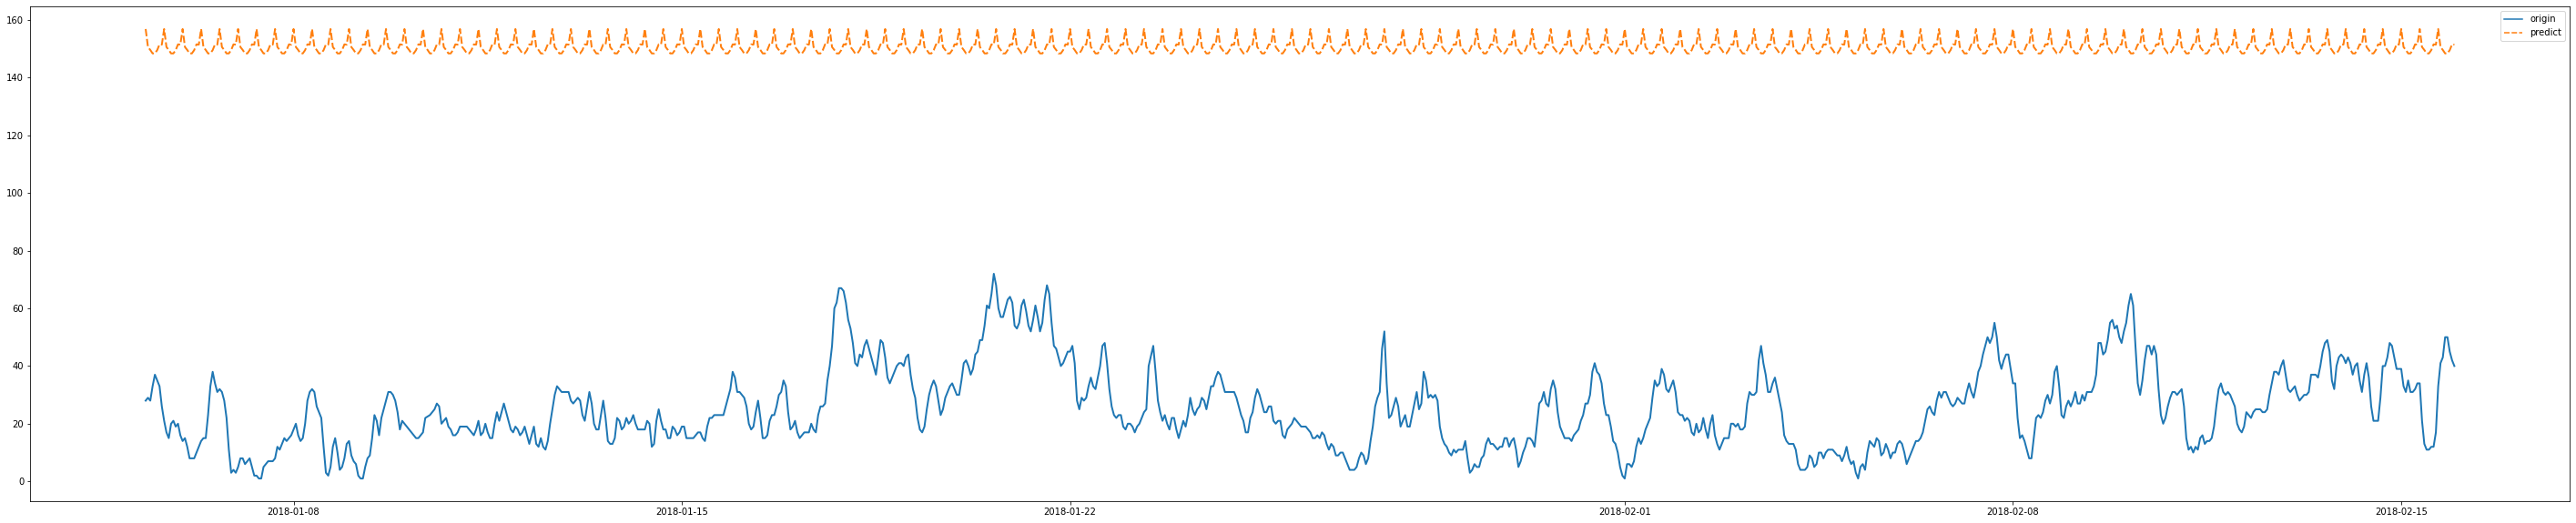

sitename: 士林
(8656, 16) (69248, 1)
[0. 5. 8.]
origin  mean ± std: 15.24 ± 20.50
predict mean ± std: 16.47 ± 0.87


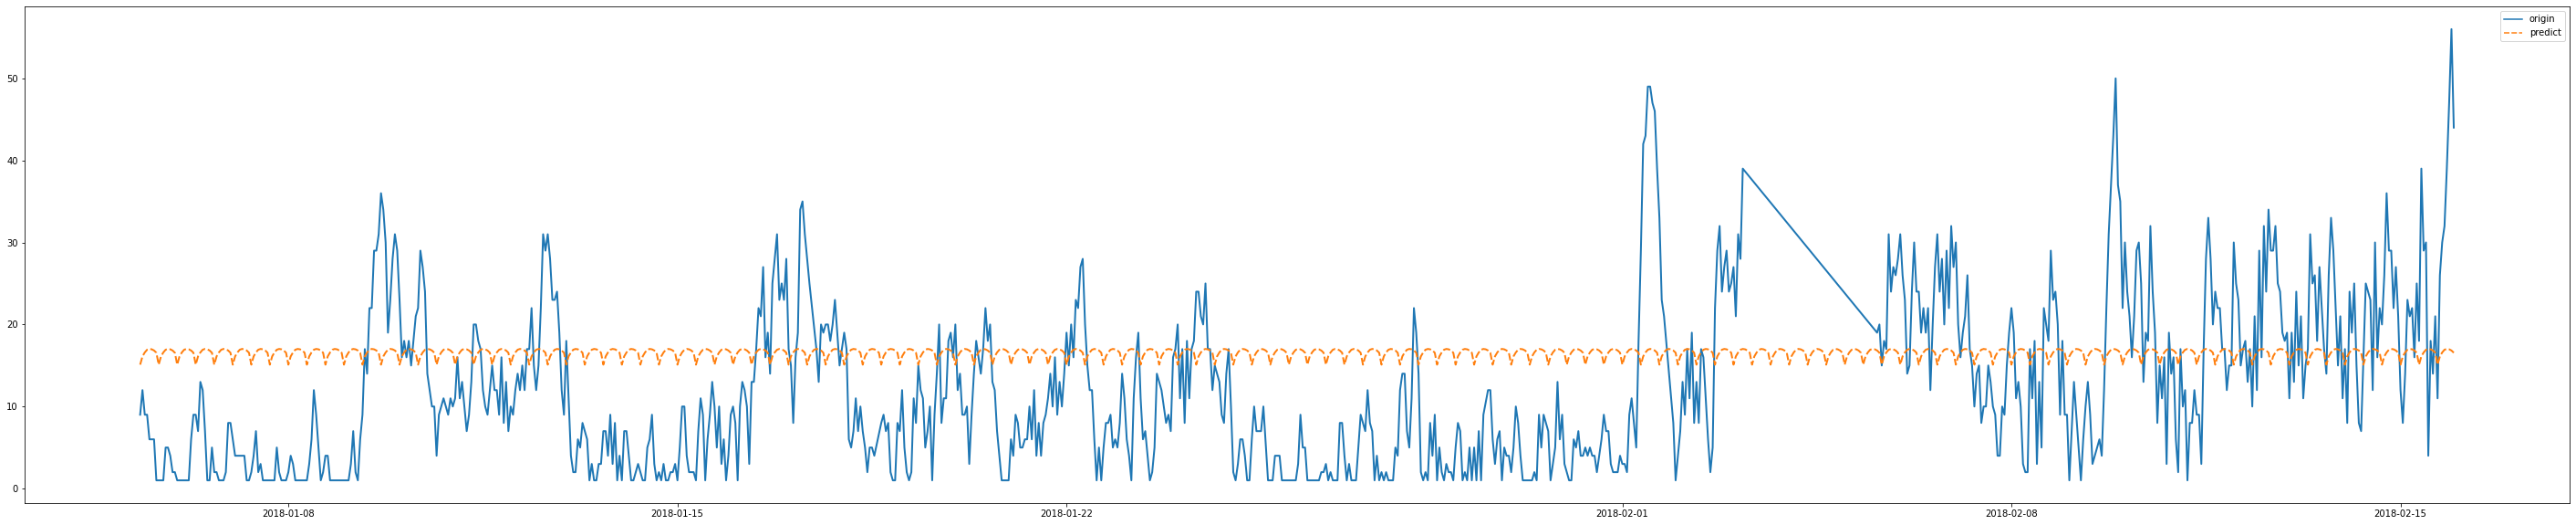

sitename: 埔里
(8656, 16) (69248, 1)
[0. 5. 8.]
origin  mean ± std: 15.69 ± 22.08
predict mean ± std: 29.93 ± 12.59


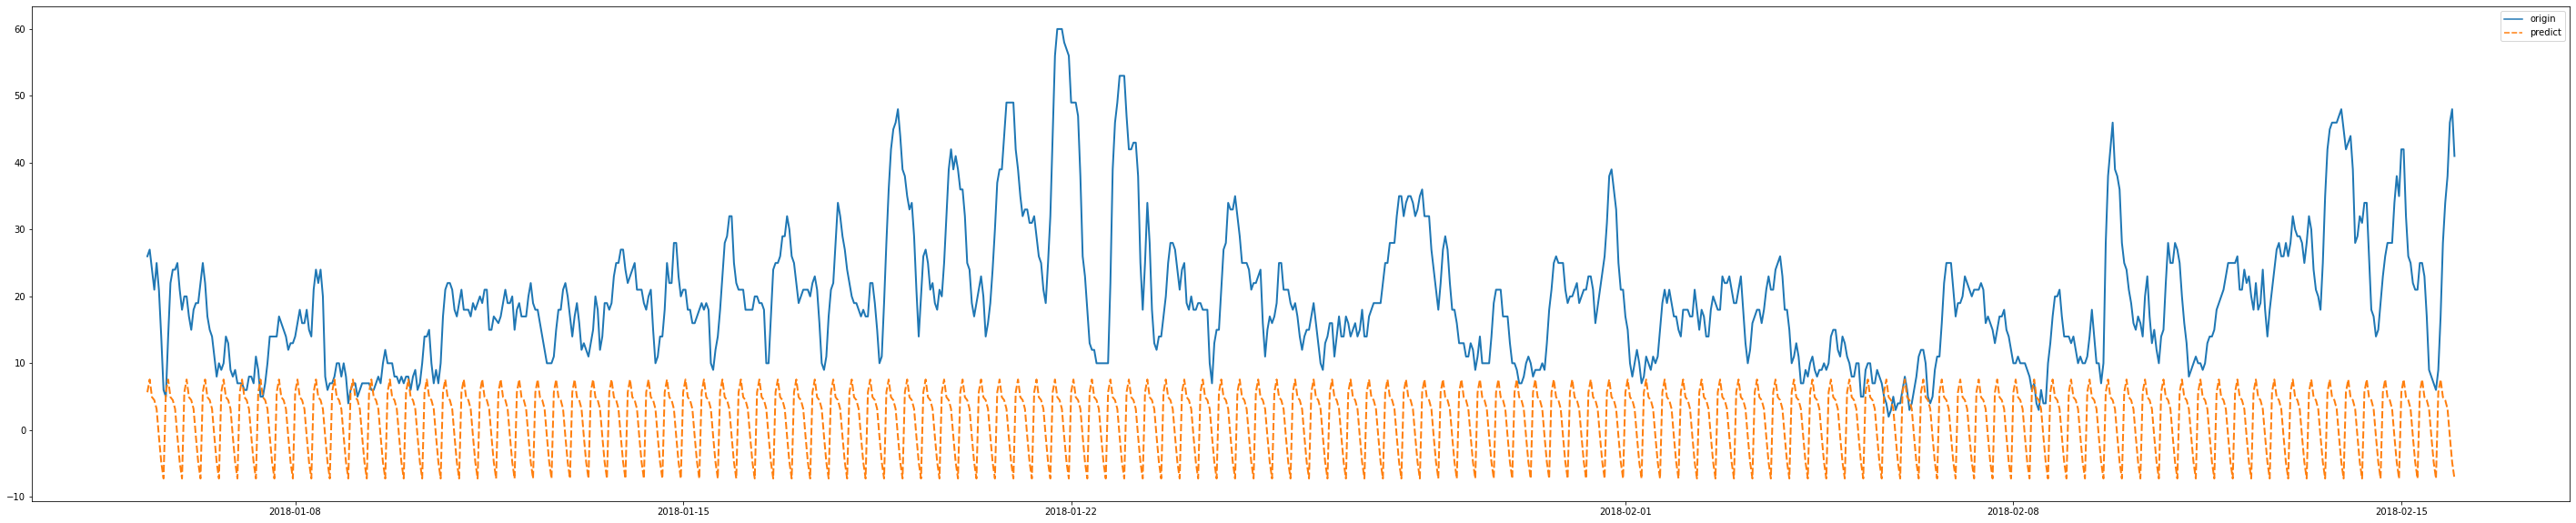

sitename: 關山
(8656, 16) (69248, 1)
[0. 5. 8.]
origin  mean ± std: 12.06 ± 20.41
predict mean ± std: 9.40 ± 0.14


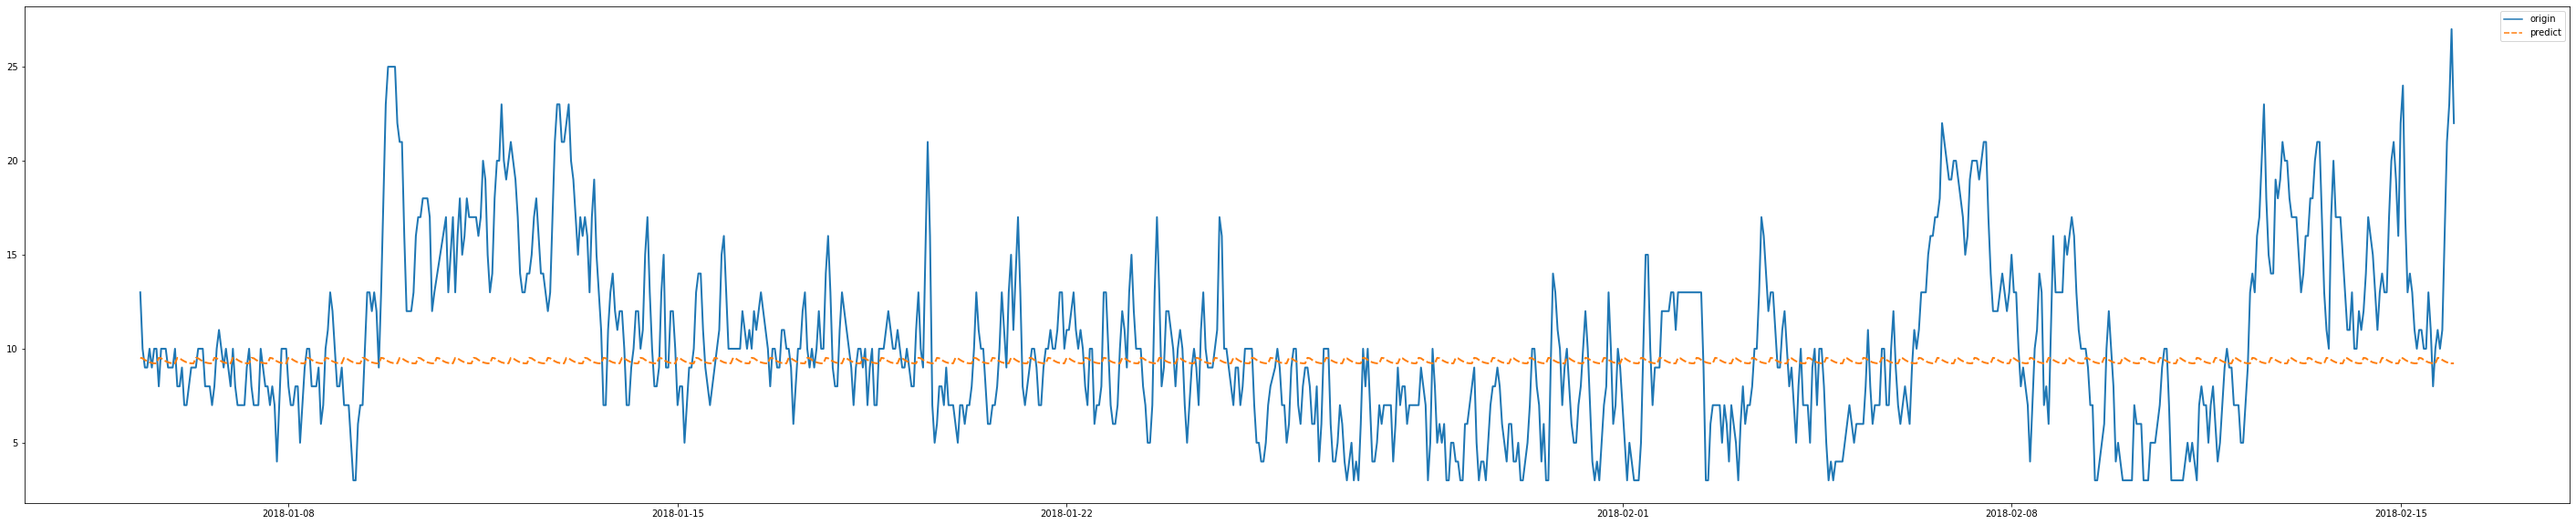

In [5]:



for sitename in ["南投", "士林", "埔里", "關山"]:
    print(f"sitename: {sitename}")
    origin_data = np.load(f"{origin_path}/{sitename}.npy")
    predict_data = np.load(f"{result_path}/{sitename}.npy")

    shift = 0
    origin_data = origin_data[80+8+8+8:]
    predict_data = np.expand_dims(predict_data, axis=-1)
    print(origin_data.shape, predict_data.shape)
    print(origin_data[0, -3:])
    print(f"origin  mean ± std: {origin_data.mean():.2f} ± {origin_data.std():.2f}")
    print(f"predict mean ± std: {predict_data.mean():.2f} ± {predict_data.std():.2f}")
    st = 0
    ed = 1000
    origin_data  = origin_data [st:ed]
    predict_data = predict_data[st:ed]
    y = np.concatenate((origin_data[:, 7:8], predict_data), axis=-1)
    
    plt.figure(figsize=(50, 10))
    # TODO: the date should be customized
    st_time = f"2018-{int(origin_data[0][-3]+1)}-{int(origin_data[0][-2])} {int(origin_data[0][-1])}:00:00"
    dates = pd.date_range(st_time, periods=predict_data.shape[0], freq="H")
    data = pd.DataFrame(y, dates, columns=["origin", "predict"])
    #sn.set_theme(style="whitegrid")
    plot = sn.lineplot(data=data, palette="tab10", linewidth=2, )
#     plot.set_title(f"{sitename}")
#     plot.figure.savefig(f"{save_path}/{sitename}.png")
    plt.show()
    #break
